# Project: Investigate the TMDB movie database!

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset I've selected is the TMDB 5000 Movie Dataset from Kaggle, but originally from The Movie Database (TMDb). If you've heard of IMDB (the Internet Movie Database), which has been acquired by Amazon, TMDb is similar in concept, but is non-commercial and community built. As such, the terms for us to analyze data are more friendly than the terms from IMDB. You can browse their site at https://www.themoviedb.org/ . The site has data for TV shows in addition to movies, but we're going to be looking at only movies, and the data that we're using hasn't been updated since 2017, since that's when Kaggle too their snapshot. The data has been modified in some ways before reaching us, like converting JSON to pipe-separated text fields, adding a release year field so it's easy to group by year, and helpfully adding inflation-adjusted fields for budget and revenue.

Upon choosing this dataset, the first question I thought of was, "What makes money?" Isn't that what everyone in the movie business wants to know? This was perhaps not the ideal choice of questions as it turned out to be difficult and I probably should have started with simpler "exploratory" questions first (oh well).

Later on, I thought of other similar questions, such as what leads to a good "popularity" rating, and what leads to good "votes" (on the TMDB website's voting system.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

We're going to load the data and have a look at the fields available.

In [2]:
df_movies = df1 = pd.read_csv('tmdb-movies.csv')

print("The columns available to us are:", df_movies.columns)

print("Number of movies in database: ", len(df_movies))

The columns available to us are: Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')
Number of movies in database:  10866


Ok, at this point we can see that we have some interesting fields to work with: in addition to the title release date, we have a popularity field, fields for votes (vote count and vote average), runtime, genres, keywords, directors, and cast, all of which look like they might be useful for predicting what movies make money, or answering other questions about movies.

### Data Cleaning

For data cleaning, I didn't actually change any of the data (though I did augment it, see below), however, it's important to note that there are lots of movies in the dataset that have "0" for either their revenue, or budget (or both). I made the assumption that no movies actually had zero budget (every studio's dream! -- movies free to produce) or zero revenue (surely at least the director's mom and dad must have paid for tickets!), therefore I assumed that zeros in these fields meant the amount was *unknown*. 

Unfortunately, this reduces the amount of data we have to work with by quite a lot.

In [3]:
df_temp = df_movies.loc[(df_movies['revenue_adj'] == 0)]
print("Number of movies with zero revenue:", len(df_temp))

df_temp = df_movies.loc[(df_movies['budget_adj'] == 0)]
print("Number of movies with zero budget:", len(df_temp))

df_temp = df_movies.loc[(df_movies['revenue_adj'] > 0)]
print("Number of movies with non-zero revenue:", len(df_temp))

df_temp = df_movies.loc[(df_movies['budget_adj'] > 0)]
print("Number of movies with non-zero budget:", len(df_temp))

df_temp = df_movies.loc[(df_movies['budget_adj'] > 0) & (df_movies['revenue_adj'] > 0)]
print("Number of movies with both non-zero budget and non-zero revenue:", len(df_temp))

Number of movies with zero revenue: 6016
Number of movies with zero budget: 5696
Number of movies with non-zero revenue: 4850
Number of movies with non-zero budget: 5170
Number of movies with both non-zero budget and non-zero revenue: 3855


So, from our original count of 10,865 movies, we are reduced to 4,849 movies with a revenue number. The revenue number is precisely the number we are trying to predict! So we can't do anything about it. We can use movies without revenue for other analysis, but for predicting revenue, we are limited to these 4,849 movies for which we have a number.

> Note: You might notice that the Python code says 4,850 movies, but in the text here I said 4,849. It turns out there is a duplicate movie, "TEKKEN", in the CSV file. I used SQL for most of the analysis, and SQL doesn't allow duplicate primary keys, drawing this duplicate entry to my attention, but Pandas doesn't care. To fully duplicate the results I'm going to present as we go forward, you'll need to remove this duplicate as per the instructions in the "Replication" section.

I also checked for movies with zeros for popularity scores, vote counts, vote averages, release years, and runtimes. There were no movies with zeros for popularity scores, vote counts, vote averages, and release years. Weirdly, there were 31 movies with no runtimes. I don't know how the runtime for a movie couldn't be known, but, like the other numerical fields, I assumed a zero in the runtime field means the amount is *unknown*, not that the movie has an actual runtime of zero. Some movies are short (usually called "short films" rather than "movies" in that case), but not *that* short.

I hinted above that I augmented the data. What I did is I added fields for budget and revenue that were logarithmic. It's a bit hard for me to explain the intuition for this, but I'll try. When you have a quantity that's unbounded at the upper end, it's often the "order of magnitude" that matters, rather than the absolute amount. In the case of movies, you want to double your revenues, for example, by switching to a bigger star actor (who probably costs more). You might double your budget to get spectacular special effects that you couldn't get on a low budget, as another example. So it's the doublings that matter. So to answer the "what makes money?" question, what we're going to want to do is find things that relate to order-of-magnitude increases in revenue. Having the revenue represented logarithmically in the first place makes this easier.

In [4]:
# the +1s are required to keep the logarithms from blowing up with 0s.
# They have little effect with the multi-million-dollar numbers typical of movies

df_movies['budget_adj_log'] = np.log(df_movies['budget_adj'] + 1)
df_movies['revenue_adj_log'] = np.log(df_movies['revenue_adj'] + 1)

We're going to go ahead and make a column with revenue "in millions" for display purposes that we'll use later on (seeing revenue in numbers like "1.902723e+09" is not meaningful to most humans).

In [5]:
df_movies['revenue_adj_mil'] = df_movies['revenue_adj'] / 1000000

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question: Relationship between budget and revenue

Before we try to tackle text fields, let's just have a look at some numerical fields and see how they relate to revenue. Let's start with budget.

3855 movies have both budget and revenue


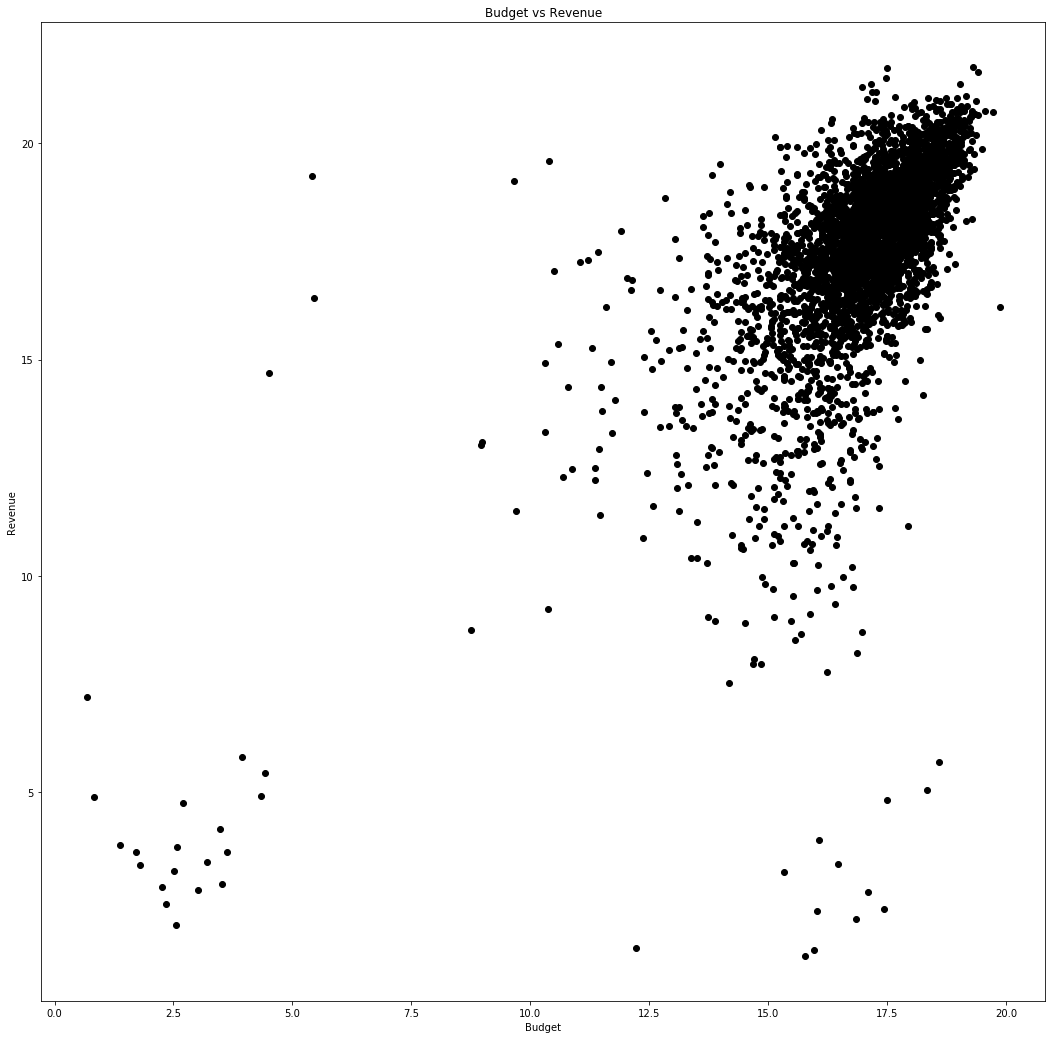

In [6]:
df_with_budget_and_revenue = df_movies.loc[(df_movies['budget_adj'] > 0) & (df_movies['revenue_adj'] > 0)]
print(len(df_with_budget_and_revenue), "movies have both budget and revenue")
df_x = df_with_budget_and_revenue['budget_adj_log']
df_y = df_with_budget_and_revenue['revenue_adj_log']

# plt.scatter(x,y, label="label line 1\nlabel line 2", color='k', marker='*', s=500)

plt.figure(figsize=(18, 18))
plt.scatter(df_x, df_y, color='k')

plt.xlabel('Budget')
plt.ylabel('Revenue')

plt.title('Budget vs Revenue')
# plt.legend()

plt.show()

Bigger budget movies tend to make more (with a lot of noise), and that's probably because they also have bigger marketing budgets, or something similarly straightforward.

Probably the most notable thing about this graph, though, is the sizable gap between the low-budget movies in the lower left corner, and the big-budget movies in the upper right.

There appears to be a cluster of high-budget movies that bombed, in the lower right corner of the graph. There really isn't a similar cluster of low-budget movies that were spectacularly profitable in the upper left corner of the graph -- just a few outliers.

We can do a statistical analysis which will show us that, yes, there's a pretty linear relationship between budget and revenue. Unfortunately, I couldn't get statsmodels to run in this Jupyter notebook, but I could get scikit-learn, so I can give you code that calculates the linear regression coefficients, but not the standard errors or p-values, so I'm just going to tell you what they are here. The linear regression gives revenue = 1.98 + 0.91 x budget. So as you increase budget, you increase revenue almost in lockstep (remember these numbers are logarithmic). But not without unpredictability. The standard errors are 0.291 and 0.017 reflecting the noise we see in the graph. p-values are < 0.001 showing the statistical analysis is confident these observations are real and not due to random chance. All of this is what we would expect from the graph above.

Since I need to include the statsmodels code, even though you can't run it, here it is:

```python
df_x = sm.add_constant(df_x)
model = sm.OLS(df_y, df_x).fit()
print(model.summary())
```

You can run the scikin-learn code in the cell below which should give you the same coefficients.


In [7]:
lm = linear_model.LinearRegression(fit_intercept = True)
x_r = df_x.values.reshape(-1, 1) # reshape we have to do to make lm.fit happy
model = lm.fit(x_r, df_y)
print("The coefficients of the linear model are:", model.intercept_, "(intercept) and ", model.coef_, "(budget)")


The coefficients of the linear model are: 1.98238839182 (intercept) and  [ 0.91423789] (budget)


### Research Question: Relationship between runtime and revenue

4850 movies have both runtime and revenue


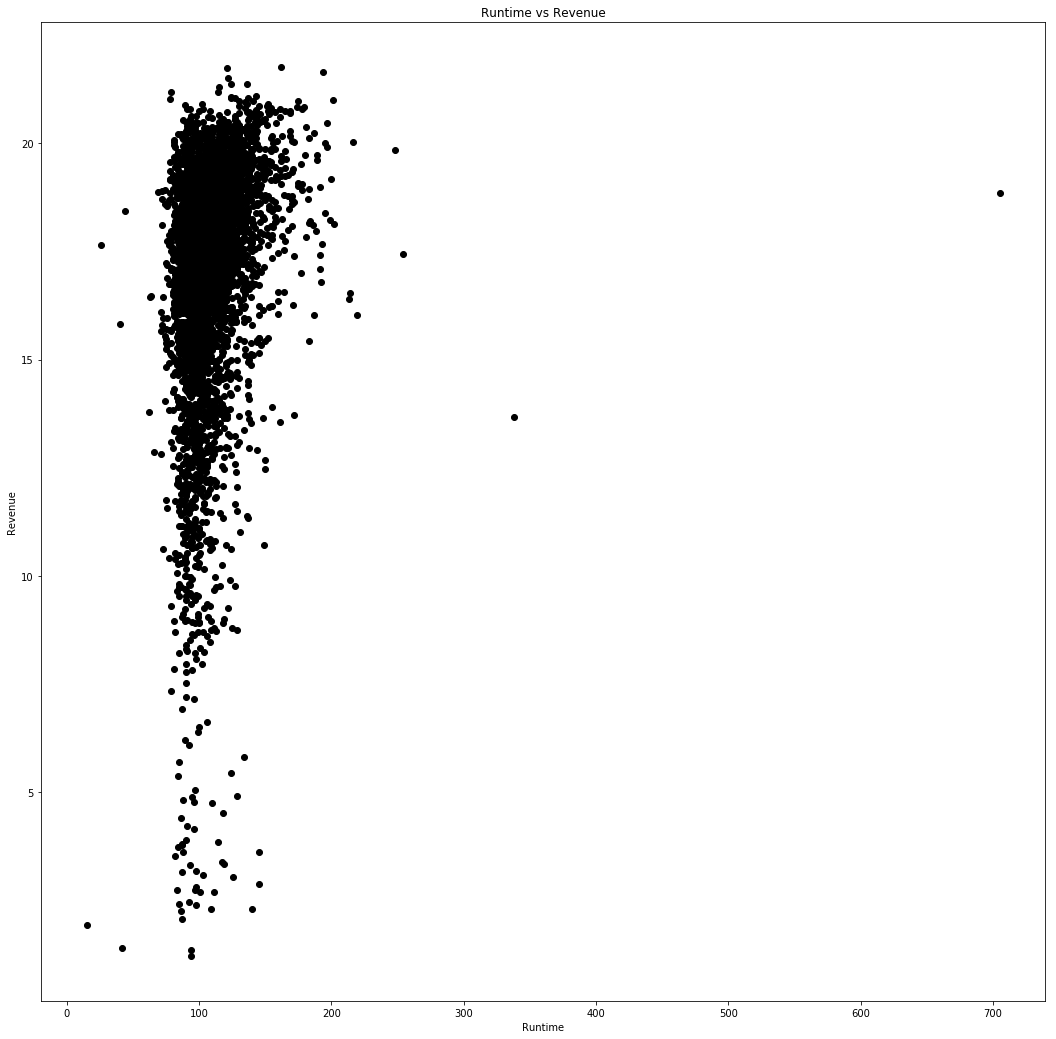

In [8]:
df_with_runtime_and_revenue = df_movies.loc[(df_movies['runtime'] > 0) & (df_movies['revenue_adj'] > 0)]
print(len(df_with_runtime_and_revenue), "movies have both runtime and revenue")

df_x = df_with_runtime_and_revenue['runtime']
df_y = df_with_runtime_and_revenue['revenue_adj_log']

plt.figure(figsize=(18, 18))
plt.scatter(df_x, df_y, color='k')

plt.xlabel('Runtime')
plt.ylabel('Revenue')

plt.title('Runtime vs Revenue')

plt.show()

When it comes to runtime, there's two interesting things to note: first, there's a sharp edge at about 90 minutes, which I suspect is simply due to convention. Second, as you go up in revenue, the runtimes extend out -- but only a bit. They tend to max out around 200 minutes. It looks like 200 minutes is about the longest audiences will sit for a movie, but they will if it's really good (well, here we're using "revenue" as a stand-in for "good").

There's probably not much point in doing statistis on this, but for sake of completeness, doing the same linear regression, we find little contribution to revenue from runtime (0.03) instead coming from the constant factor (intercept) (13.7), which has a standard error of 0.195, about what we would expect given the noise we see around the 90-minute mark in the graph. p-values are < 0.001 meaning this isn't likely due to random chance.

In [9]:
lm = linear_model.LinearRegression(fit_intercept = True)
x_r = df_x.values.reshape(-1, 1) # reshape we have to do to make lm.fit happy
model = lm.fit(x_r, df_y)
print("The coefficients of the linear model are:", model.intercept_, "(intercept) and ", model.coef_, "(runtime)")

The coefficients of the linear model are: 13.7484424226 (intercept) and  [ 0.03018952] (runtime)


### Research Question: Relationship between release year and revenue

There's only one more numeric field (not counting popularity and votes, which we'll get to later) that we can compare to revenue, so we might as well have a look.

4850 movies have both release year and revenue


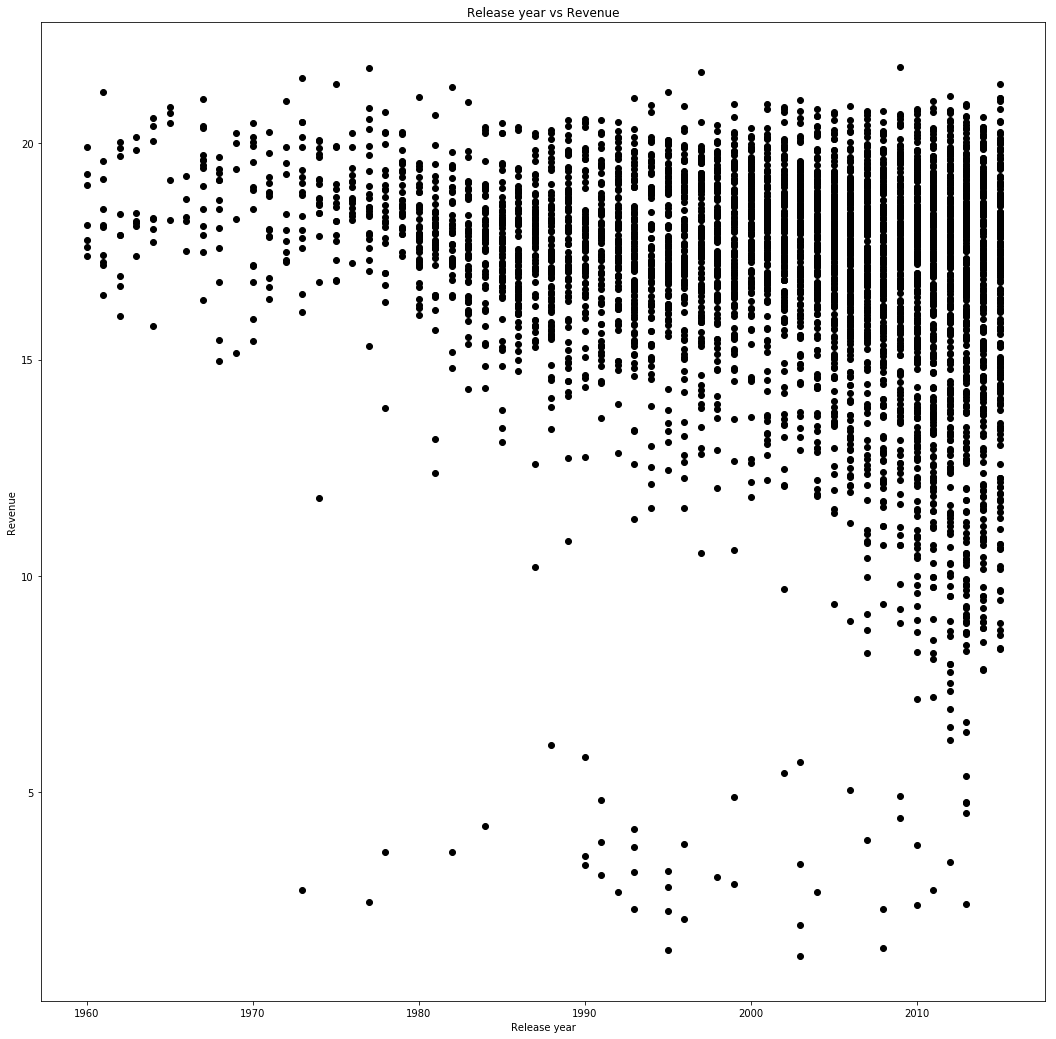

In [10]:
df_with_year_and_revenue = df_movies.loc[(df_movies['release_year'] > 0) & (df_movies['revenue_adj'] > 0)]
print(len(df_with_year_and_revenue), "movies have both release year and revenue")

df_x = df_with_runtime_and_revenue['release_year']
df_y = df_with_runtime_and_revenue['revenue_adj_log']

plt.figure(figsize=(18, 18))
plt.scatter(df_x, df_y, color='k')

plt.xlabel('Release year')
plt.ylabel('Revenue')

plt.title('Release year vs Revenue')

plt.show()

Alrighty, I would say mainly what this shows is that over time, there's more movies! And as the number of movies increases, it's a bit harder to get up to that top tier in revenue. I'm referring to how the bottom edge of the wedge angles downward as we go right. If you're a movie studio executive looking for clues to what makes a high-revenue movie, this graph isn't much help unless you can invent a time machine.

We also see a gap with some movies along the bottom. We can't actually tell in this graph which of these are low-budget movies -- remember we saw a gap earlier between low- and high-budget movies -- and which are high-budget movies that bombed.

I'm going to skip doing stats on this graph -- hopefully the graph itself is enough. Let's move on to...

### Research Question: Relationship between genre and revenue

Ok, now we get to the challenging part: the text fields. Now we get to the part where I max out what I can do here in the Jupyter notebook and explain how I managed to analyze this using SQL. After hours of frustrating attempts to do this in Pandas, I decided to see how easy it was to do in SQL, and it turned out to be pretty easy -- the Python interface to SQLite turned out to be simple, and when I tried it out, it worked. I had to write a tool to turn SQL queries into Pandas dataframes, and had to write quite a bit of "helper" functions, so it took a bit of coding to get it all to work. Anyway, what I'm going to show you here is the results from that code, not the code itself running here in the Jupyter notebook, but you can pull the code from Github and run it yourself from scratch if you want from here: (insert Github link here)

Basically what I did for the following text fields: genre, keywords, director, cast, and production companies, was to find all the entries above some threshhold (I chose 25 because I figured any genre, keyword, director, etc, that appeared less than 25 times was not something we could draw any statistically significant conclusions from) and turn them into a bionomial (0 or 1) field for linear regression. Then we can run a linear regression model and find out which genres, etc, contribute to revenue.

It turns out when you run that linear regression for genres, here's what comes out:


```
                             coef    std err          t      P>|t|      [0.025      0.975]

const                     16.8496      0.109    154.002      0.000      16.635      17.064
genres_comedy             -0.0565      0.092     -0.611      0.541      -0.238       0.125
genres_action              0.4238      0.103      4.105      0.000       0.221       0.626
genres_thriller           -0.0069      0.100     -0.069      0.945      -0.203       0.190
genres_crime               0.3292      0.112      2.929      0.003       0.109       0.550
genres_adventure           0.8858      0.113      7.807      0.000       0.663       1.108
genres_science_fiction     0.1482      0.122      1.214      0.225      -0.091       0.387
genres_animation           0.1666      0.201      0.828      0.408      -0.228       0.561
genres_family              0.7802      0.150      5.196      0.000       0.486       1.075
genres_drama              -0.4936      0.090     -5.508      0.000      -0.669      -0.318
genres_romance             0.1764      0.104      1.695      0.090      -0.028       0.380
genres_music              -0.0541      0.194     -0.279      0.780      -0.435       0.327
genres_horror             -0.6009      0.131     -4.593      0.000      -0.857      -0.344
genres_mystery             0.3254      0.139      2.336      0.020       0.052       0.599
genres_fantasy             0.3647      0.134      2.727      0.006       0.102       0.627
genres_documentary        -2.9042      0.271    -10.728      0.000      -3.435      -2.373
genres_war                 0.6286      0.235      2.680      0.007       0.169       1.088
genres_western             0.1700      0.321      0.530      0.596      -0.459       0.800
genres_history             0.5211      0.224      2.327      0.020       0.082       0.960
genres_foreign            -1.5794      0.460     -3.430      0.001      -2.482      -0.677
genres_tv_movie            0.4927      2.552      0.193      0.847      -4.511       5.497
```

I'd like to direct your attention first to the p-values column. We're going to toss everything with more than 0.05 in this column, since any relationship is too likely to be due to chance if the p-value is that big. That means with genres like "thriller", we can't draw any conclusions. On the other hand, "documentary" has a p-value of < 0.001, and has a coefficient of -2.9 -- that means being a documentary *reduces* revenue, and we can say this with some confidence. If you're a movie studio executive looking to make money, you should probably stay away from the "documentary" genre!

So which genres are the best to make money? "Adventure" is looking pretty good, with a revenue-raising coefficient of 0.88 and a p-value of < 0.001. "Family" also is looking good with a coefficient of 0.78 and a p-value of < 0.001. "War" has a p-value a little higher (0.007) but has a revenue-raising coefficient of 0.62.

Here's what the same table looks like with p-values > 0.05 filtered out and sorted by coefficient:

```
                             coef    std err          t      P>|t|      [0.025      0.975]

genres_adventure           0.8858      0.113      7.807      0.000       0.663       1.108
genres_family              0.7802      0.150      5.196      0.000       0.486       1.075
genres_war                 0.6286      0.235      2.680      0.007       0.169       1.088
genres_history             0.5211      0.224      2.327      0.020       0.082       0.960
genres_action              0.4238      0.103      4.105      0.000       0.221       0.626
genres_fantasy             0.3647      0.134      2.727      0.006       0.102       0.627
genres_crime               0.3292      0.112      2.929      0.003       0.109       0.550
genres_mystery             0.3254      0.139      2.336      0.020       0.052       0.599
genres_romance             0.1764      0.104      1.695      0.090      -0.028       0.380
genres_animation           0.1666      0.201      0.828      0.408      -0.228       0.561
genres_science_fiction     0.1482      0.122      1.214      0.225      -0.091       0.387
genres_drama              -0.4936      0.090     -5.508      0.000      -0.669      -0.318
genres_horror             -0.6009      0.131     -4.593      0.000      -0.857      -0.344
genres_foreign            -1.5794      0.460     -3.430      0.001      -2.482      -0.677
genres_documentary        -2.9042      0.271    -10.728      0.000      -3.435      -2.373

```

Since "Adventure" is the top genre, let's have a look at the highest-revenue adventure films.

In [11]:
def print_top_from_list(df_movies, title, id_list):
    top_title_list = []
    top_revenue_list = []
    for idcode in id_list:
        top_title_list.append(df_movies.loc[(df_movies['id'] == idcode)]['original_title'].values[0])
        top_revenue_list.append(df_movies.loc[(df_movies['id'] == idcode)]['revenue_adj_mil'].values[0])
    df_combined = pd.DataFrame({'Movie Title': top_title_list, 'Revenue (millions)': top_revenue_list})
    print(title)
    print(df_combined)

print_top_from_list(df_movies, "Genre: Adventure", [ 19995, 11, 578, 140607, 601, 12230, 24428, 1891, 135397, 329, 9325, 122, 99861, 12445, 1892, 1893, 671, 109445, 58, 68721])

Genre: Adventure
                                      Movie Title  Revenue (millions)
0                                          Avatar         2827.123750
1                                       Star Wars         2789.712242
2                                            Jaws         1907.005842
3                    Star Wars: The Force Awakens         1902.723130
4                      E.T. the Extra-Terrestrial         1791.694309
5                  One Hundred and One Dalmatians         1574.814740
6                                    The Avengers         1443.191435
7                         The Empire Strikes Back         1424.626188
8                                  Jurassic World         1392.445893
9                                   Jurassic Park         1388.863312
10                                The Jungle Book         1345.551059
11  The Lord of the Rings: The Return of the King         1326.278010
12                        Avengers: Age of Ultron         1292.632337
13 

We created a function to show titles and revenue from a predetermined list, because we're going to be doing that again. The ID list comes from Python code run outside the notebook -- instructions for getting it are in the "Replication" section at the end. (The reason for using code outside the notebook is that statsmodels didn't run in the notebook and putting the rest of the code in the notebook would clutter the notebook with a boatload of code and detract from the data exploration narrative.)

Anyway, for comparison, Let's compare these top "adventure" movies with the top "documentary" movies.

In [12]:
print_top_from_list(df_movies, "Genre: Documentary", [ 1777, 10946, 21736, 54518, 16052, 12094, 1781, 1430, 9372, 126509, 101267, 181330, 2359, 24982, 36970, 67675, 22074, 11194, 295592, 57586 ])

Genre: Documentary
                       Movie Title  Revenue (millions)
0                  Fahrenheit 9/11          137.511206
1                            Earth          114.631876
2                          Everest          102.263367
3   Justin Bieber: Never Say Never           95.429438
4                           Selena           81.507619
5               Jackass Number Two           78.722488
6            An Inconvenient Truth           50.019627
7            Bowling for Columbine           43.113438
8                    Super Size Me           32.988367
9            2016: Obama's America           31.721459
10          Katy Perry: Part of Me           31.082239
11      Kevin Hart: Let Me Explain           30.169204
12                           Sicko           25.806383
13             Ghosts of the Abyss           20.199442
14                          Oceans           19.724679
15         Glee: The Concert Movie           18.092106
16        Capitalism: A Love Story           1

As you can see, much lower revenues.

### Research Question: Relationship between keywords and revenue

Keywords are different from genres. For one thing, there's a whole lot more of them. They seem to be a lot more specific, compared with genres which just indicate which of very broad categories a film belongs in. 

```
                                            coef    std err          t      P>|t|      [0.025      0.975]

const                                    16.7574      0.058    286.709      0.000      16.643      16.872
keywords_hotel                            0.4429      0.462      0.958      0.338      -0.464       1.350
keywords_witch                            1.0297      0.438      2.352      0.019       0.171       1.888
keywords_chicago                          0.8023      0.514      1.560      0.119      -0.206       1.810
keywords_drug_dealer                      0.4586      0.488      0.940      0.347      -0.498       1.415
keywords_escape                           0.6442      0.575      1.121      0.262      -0.483       1.771
keywords_animation                        2.2045      0.554      3.981      0.000       1.119       3.290
keywords_based_on_novel                   0.5665      0.196      2.884      0.004       0.181       0.952
keywords_adultery                         0.2339      0.438      0.534      0.593      -0.624       1.092
keywords_loss_of_father                   0.9134      0.561      1.628      0.104      -0.186       2.013
keywords_individual                       0.3274      0.549      0.597      0.551      -0.749       1.404
keywords_dancing                          1.0322      0.508      2.033      0.042       0.037       2.028
   .
   .
   .
```

I'm going to stop here because this list goes on and on. In fact there's 224 entries. Remember this is after pre-discarding all keywords that appear on less than 25 movies. So rather than give you the full list, I'm going to give you the following list that has only the entries with low p-values (less than 0.05). There's still a lot of them (42 items). Since the order is determined by the order they appear in the original dataset, I've decided to sort them by their coefficients, the same as for genres above.

```
                                            coef    std err          t      P>|t|      [0.025      0.975]

keywords_animation                        2.2045      0.554      3.981      0.000       1.119       3.290
keywords_3d                               1.7845      0.525      3.397      0.001       0.755       2.814
keywords_marvel_comic                     1.7380      0.526      3.307      0.001       0.708       2.768
keywords_flying                           1.7259      0.670      2.575      0.010       0.412       3.040
keywords_saving_the_world                 1.6760      0.475      3.525      0.000       0.744       2.608
keywords_suicide_attempt                  1.4957      0.598      2.502      0.012       0.324       2.668
keywords_werewolf                         1.4621      0.720      2.032      0.042       0.051       2.873
keywords_san_francisco                    1.4470      0.464      3.115      0.002       0.536       2.358
keywords_street_gang                      1.3522      0.615      2.200      0.028       0.147       2.557
keywords_american_football                1.3518      0.568      2.378      0.017       0.237       2.466
keywords_magic                            1.3336      0.490      2.724      0.006       0.374       2.294
keywords_space_marine                     1.3122      0.551      2.382      0.017       0.232       2.392
keywords_secret_agent                     1.3107      0.619      2.118      0.034       0.097       2.524
keywords_loss_of_lover                    1.2938      0.572      2.263      0.024       0.173       2.415
keywords_indian                           1.2918      0.565      2.285      0.022       0.183       2.400
keywords_love_of_ones_life                1.2598      0.417      3.018      0.003       0.442       2.078
keywords_secret_identity                  1.2521      0.507      2.470      0.014       0.258       2.246
keywords_helicopter                       1.1487      0.445      2.584      0.010       0.277       2.020
keywords_artificial_intelligence          1.1067      0.533      2.077      0.038       0.062       2.151
keywords_assassination                    1.0532      0.509      2.069      0.039       0.055       2.051
keywords_baseball                         1.0519      0.489      2.152      0.031       0.094       2.010
keywords_spy                              1.0382      0.451      2.301      0.021       0.154       1.923
keywords_dancing                          1.0322      0.508      2.033      0.042       0.037       2.028
keywords_witch                            1.0297      0.438      2.352      0.019       0.171       1.888
keywords_hero                             1.0267      0.486      2.111      0.035       0.073       1.980
keywords_romantic_comedy                  0.9777      0.493      1.984      0.047       0.012       1.944
keywords_martial_arts                     0.9700      0.375      2.590      0.010       0.236       1.704
keywords_holiday                          0.9452      0.439      2.155      0.031       0.085       1.805
keywords_alien                            0.9162      0.423      2.164      0.031       0.086       1.746
keywords_world_war_ii                     0.8988      0.370      2.431      0.015       0.174       1.624
keywords_london                           0.7606      0.318      2.391      0.017       0.137       1.384
keywords_sequel                           0.7588      0.338      2.244      0.025       0.096       1.422
keywords_dystopia                         0.7231      0.296      2.439      0.015       0.142       1.304
keywords_based_on_novel                   0.5665      0.196      2.884      0.004       0.181       0.952
keywords_sex                             -0.6151      0.254     -2.421      0.016      -1.113      -0.117
keywords_revenge                         -0.8513      0.338     -2.520      0.012      -1.514      -0.189
keywords_infidelity                      -1.2213      0.463     -2.638      0.008      -2.129      -0.314
keywords_paranoia                        -1.4105      0.638     -2.212      0.027      -2.661      -0.161
keywords_woman_director                  -1.4886      0.252     -5.899      0.000      -1.983      -0.994
keywords_eroticism                       -2.0512      0.731     -2.808      0.005      -3.483      -0.619
keywords_zombies                         -2.1052      0.603     -3.494      0.000      -3.287      -0.924
keywords_super_powers                    -2.3684      1.204     -1.968      0.049      -4.728      -0.008
keywords_independent_film                -2.4955      0.230    -10.866      0.000      -2.946      -2.045
```

One thing I should point out, before continuing, is that "dance" and "dancing" are two separate keywords in this dataset. And as you can see, "dancing" made the list of low p-value keywords, but "dance" didn't. "Dance" has a p-value of 0.3 and a coefficient of -0.6437. There's no reason why "dancing" should have a low p-value and a positive coefficient while "dance" has the reverse -- in all likelihood, the two keywords mean the same thing, but some users to the TMDb website arbitrarily entered "dance" while others entered "dancing". So our keywords have a lot of arbitrariness to them that our statistics package is unaware of.

Anyway, as you can see, "animation" has the highest coefficient, at 2.2, followed by "3d" (1.78), "marvel comic" (1.74), "flying" (1.73), and "saving the world" (1.68). So if you want to make a movie that makes lots of money -- I'm going to sound like I'm making this up, but you can see I'm not! -- you should make a 3D animated Marvel Comics movie with lots of flying, and the world gets saved! Maybe there's an opportunity for a Marvel-Pixar collaboration in the future?

What about on the negative end -- what keywords correlate negatively with revenue? Sadly, "independent film" did the worst, with a coefficient of -2.5 (and reliably -- p-value < 0.001). Kind of a bleak state of affairs for all the aspiring indepentend film producers out there. Surprisingly (given how positively "marvel comic" did), "super powers" has a negative coefficient of -2.4. After that we have zombies at -2.1. Time to toss that zombie apacolypse screenplay you've been working on in the trash? (Or you might note that while zombies are bad, werewolves are good, with a coefficient of 1.46, so you might try to re-work your zombie apacolypse screenplay into a werewolf apocalypse screenplay.)

Also should mention, there is a DC comics keyword, but the p-value was to high to include (p-value was about 0.21). If your intuition told you DC Comics movies are less reliably successful than Marvel Comics movies, these stats would appear to confirm it.

As before, let's have a look at the top and bottom categories and see what movies in them have the highest revenue. Animation is on top so let's have a look at that.

In [13]:
print_top_from_list(df_movies, "Keyword: Animation", [ 12230, 10193, 12, 150540, 14160, 62211, 49013, 10530, 10567, 11970, 105864, 10198, 10865, 533, 151960, 16690, 49948, 140823, 14175, 22586 ])

Keyword: Animation
                       Movie Title  Revenue (millions)
0   One Hundred and One Dalmatians         1574.814740
1                      Toy Story 3         1063.171911
2                     Finding Nemo         1024.886690
3                       Inside Out          785.411575
4                               Up          743.337082
5              Monsters University          695.996592
6                           Cars 2          542.719817
7                       Pocahontas          495.228689
8                         Dinosaur          448.581529
9                         Hercules          343.299362
10               The Good Dinosaur          305.371921
11       The Princess and the Frog          271.425431
12       Atlantis: The Lost Empire          229.122951
13    The Curse of the Were-Rabbit          214.885767
14                          Planes          205.729565
15            Return to Never Land          133.182288
16                   Fantasia 2000          11

And now let's have a look at the "independent film" keyword:

In [14]:
print_top_from_list(df_movies, "Keyword: Independent film", [ 30315, 41659, 12498, 2295, 12767, 10546, 19326, 32579, 16727, 2074, 26149, 9515, 15644, 13668, 24100, 10440, 793, 9787, 9770, 10707 ])

Keyword: Independent film
                 Movie Title  Revenue (millions)
0     Kingdom of the Spiders           61.162278
1                    My Life           41.486973
2                Sling Blade           34.026133
3                  Clerks II           29.084327
4           Cold Creek Manor           25.347622
5   The Crow: City of Angels           24.908912
6                  Jury Duty           24.347405
7              La Misma Luna           23.609465
8               The Namesake           21.783558
9     Flirting with Disaster           20.439575
10        Music of the Heart           19.451732
11               The Matador           19.313468
12                 Paparazzi           19.170447
13         Catch and Release           17.478137
14        The Little Vampire           17.165841
15  Manhattan Murder Mystery           17.035256
16               Blue Velvet           17.011868
17          Lords of Dogtown           14.975299
18                  Mad City           14.3

Remember, these are just the films with the highest revenues with the keyword "independent film", but our linear regression analysis was done on all the films. I'm just listing some titles to give you a "feel" for what kinds of films get this keyword.

### Research Question: Relationship between director and revenue

When it comes to directors, the picture is much simpler. First, only four directors, Woody Allen, Martin Scorsese, Clint Eastwood, and Steven Spielberg passed the "25" test. Apparently, while it's easy for the same tag to be applied to hundreds of films, it's very hard for one person to make a lot of films in one lifetime, especially if you're trying to make films that are really, really good and will make a lot of money. Furthermore, Woody Allen and Martin Scorsese failed our p-value test (p-value of 0.32 for Woody Allen, 0.096 for Martin Scorsese), leaving us with only Client Eastwood and Steven Spielberg. Steven Spielberg has the highest coefficient (2.73) as well as the lowest p-value (less than 0.001), making Steven Spielberg stand out as the one director who most reliably makes money-making films.

```
                                coef    std err          t      P>|t|      [0.025      0.975]


director_steven_spielberg     2.7305      0.507      5.383      0.000       1.736       3.725
director_clint_eastwood       1.5681      0.526      2.980      0.003       0.536       2.600
```

Let's have a look at Steven Spielberg's top films.

In [15]:
print_top_from_list(df_movies, "Director: Steven Spielberg", [ 578, 601, 329, 840, 85, 89, 217, 87, 74, 857 ])

Director: Steven Spielberg
                                         Movie Title  Revenue (millions)
0                                               Jaws         1907.005842
1                         E.T. the Extra-Terrestrial         1791.694309
2                                      Jurassic Park         1388.863312
3                 Close Encounters of the Third Kind         1092.964989
4                            Raiders of the Lost Ark          935.116878
5                 Indiana Jones and the Last Crusade          834.061065
6  Indiana Jones and the Kingdom of the Crystal S...          796.694460
7               Indiana Jones and the Temple of Doom          698.980999
8                                  War of the Worlds          660.714468
9                                Saving Private Ryan          644.556401


### Research Question: Relationship between cast and revenue

```
                                        coef    std err          t      P>|t|      [0.025      0.975]

performers_tom_cruise                 2.4596      0.459      5.360      0.000       1.560       3.359
performers_eddie_murphy               2.0942      0.455      4.605      0.000       1.203       2.986
performers_tom_hanks                  2.0934      0.438      4.777      0.000       1.234       2.953
performers_michael_keaton             1.9294      0.642      3.004      0.003       0.670       3.189
performers_harrison_ford              1.9072      0.439      4.345      0.000       1.047       2.768
performers_jim_carrey                 1.8495      0.501      3.694      0.000       0.868       2.831
performers_arnold_schwarzenegger      1.8204      0.490      3.712      0.000       0.859       2.782
performers_adam_sandler               1.7735      0.497      3.571      0.000       0.800       2.747
performers_clint_eastwood             1.7142      0.472      3.629      0.000       0.788       2.640
performers_mel_gibson                 1.6172      0.505      3.199      0.001       0.626       2.608
performers_leonardo_dicaprio          1.6142      0.584      2.766      0.006       0.470       2.758
performers_sylvester_stallone         1.5074      0.437      3.448      0.001       0.650       2.364
performers_denzel_washington          1.4479      0.455      3.180      0.001       0.555       2.340
performers_sean_connery               1.4468      0.516      2.802      0.005       0.435       2.459
performers_jack_nicholson             1.4414      0.617      2.336      0.020       0.232       2.651
performers_john_travolta              1.4371      0.486      2.955      0.003       0.484       2.390
performers_cameron_diaz               1.4322      0.490      2.924      0.003       0.472       2.392
performers_salma_hayek                1.4268      0.692      2.063      0.039       0.071       2.783
performers_brad_pitt                  1.4218      0.449      3.164      0.002       0.541       2.303
performers_ben_stiller                1.4066      0.509      2.761      0.006       0.408       2.405
performers_johnny_depp                1.3910      0.442      3.147      0.002       0.525       2.257
performers_robert_redford             1.3849      0.554      2.501      0.012       0.299       2.470
performers_richard_gere               1.3817      0.508      2.719      0.007       0.385       2.378
performers_john_hurt                  1.3737      0.649      2.116      0.034       0.101       2.646
performers_sandra_bullock             1.3675      0.519      2.637      0.008       0.351       2.384
performers_pierce_brosnan             1.3625      0.590      2.310      0.021       0.206       2.519
performers_reese_witherspoon          1.3563      0.642      2.114      0.035       0.098       2.614
performers_mark_wahlberg              1.3465      0.486      2.772      0.006       0.394       2.299
performers_steve_martin               1.3446      0.566      2.374      0.018       0.234       2.455
performers_robin_williams             1.3246      0.429      3.084      0.002       0.483       2.167
performers_kevin_costner              1.2954      0.492      2.634      0.008       0.331       2.259
performers_jon_voight                 1.2808      0.591      2.167      0.030       0.122       2.440
performers_scarlett_johansson         1.2736      0.559      2.276      0.023       0.177       2.370
performers_anthony_hopkins            1.2718      0.532      2.393      0.017       0.230       2.314
performers_will_ferrell               1.2649      0.553      2.288      0.022       0.181       2.349
performers_michael_caine              1.2621      0.528      2.393      0.017       0.228       2.296
performers_george_clooney             1.2180      0.533      2.284      0.022       0.172       2.264
performers_robert_downey_jr           1.2155      0.502      2.422      0.015       0.232       2.199
performers_john_leguizamo             1.2084      0.556      2.173      0.030       0.118       2.298
performers_ralph_fiennes              1.1993      0.533      2.248      0.025       0.154       2.245
performers_jeff_bridges               1.1926      0.565      2.109      0.035       0.084       2.301
performers_bruce_willis               1.1391      0.382      2.985      0.003       0.391       1.887
performers_gary_oldman                1.1338      0.554      2.048      0.041       0.048       2.219
performers_michael_douglas            1.1271      0.485      2.324      0.020       0.176       2.078
performers_nicolas_cage               1.1207      0.391      2.863      0.004       0.353       1.888
performers_tommy_lee_jones            1.1204      0.533      2.102      0.036       0.076       2.165
performers_dustin_hoffman             1.0346      0.486      2.131      0.033       0.083       1.986
```

I changed "cast" to "performers" because, as it turns out, "cast" is a reserved keyword in SQL. Anyway, I've taken the liberty of removing all the entries from this list where the p-value is above 0.05, and sorted it by coefficient as before.

The top performer -- where "top" is defined as "best predicts generating revenue", is Tom Cruise, with a coefficient of 2.46. After him, we have Eddie Murphy (2.09), Tom Hanks (2.09), Michael Keaton (1.93), Harrison Ford (1.91), Jim Carrey (1.85), Arnold Schwarzenegger (1.82), Adam Sandler (1.77), and Clint Eastwood (1.71) who has the unique distinction of showing up near the top of both the director and performer lists. I was surprised to see Adam Sandler on the list, because I discovered from the IMDB forums (which don't exist anymore -- Amazon, who owns IMDB, shut them down) that he has an army of haters. But I guess while there's a lot of highly vocal people who hate Adam Sandler, there's another massive army of of people who quietly sneak off and watch his films without telling anybody. (I've heard when Netflix switched from mailing people DVDs, which would involve them making lists of movies they wanted to watch that would go into a queue, to delivering video on demand over the internet, they discovered that people would name high-minded movies when making a list for DVDs, but click on "guilty pleasure" movies like Adam Sandler movies when they could watch them instantly. And Netflix adjusted their on-line recommendation system accordingly.)

Curiously, the top performers are all male -- in fact we have to go all the way down to number 17 to get to the first woman, Cameron Diaz (1.43), followed quickly by Salma Hayek (1.43).

You'll also note the lack of performers with negative coefficients. I suspect (but will not attempt to prove statistically here -- so this is just a guess, a hypothesis) that something akin to the "gambler's ruin" effect prevents this. The idea behind "gambler's ruin" is that even if the odds between you and the house (suppose you are at a Las Vegas casino) are exactly 50/50 (which is never actually the case, but never mind that), because the house has boatloads of money and you don't, you're going to hit zero first and when you hit zero, you're out of the game. So with performers, performers that give bad performances a few times are probably not given 3rd or 4th chances, so their careers get cut short. (Hope it's ok to proffer a little speculation here.)

There were some performers with negative coefficients in the dataset that you don't see on the above list because they were above my arbitrary 0.05 p-value cutoff. For example, just above the cutoff at 0.053 was Sam Rockwell.

Let's have a look at some top Tom Cruise movies.


In [16]:
print_top_from_list(df_movies, "Cast: Tom Cruise", [ 744, 955, 56292, 74, 380, 954, 177677, 616, 180, 956 ])

Cast: Tom Cruise
                            Movie Title  Revenue (millions)
0                               Top Gun          709.881085
1                Mission: Impossible II          691.886949
2  Mission: Impossible - Ghost Protocol          673.453791
3                     War of the Worlds          660.714468
4                              Rain Man          654.259434
5                   Mission: Impossible          636.297140
6    Mission: Impossible - Rogue Nation          627.743452
7                      The Last Samurai          541.420466
8                       Minority Report          434.441663
9               Mission: Impossible III          430.342088


### Research Question: Relationship between production companies and revenue

```
                                                                  coef    std err          t      P>|t|

production_companies_dreamworks_animation                       3.6817      0.443      8.305      0.000
production_companies_marvel_studios                             3.3968      0.588      5.774      0.000
production_companies_walt_disney_productions                    3.2402      0.783      4.138      0.000
production_companies_walt_disney_pictures                       3.0298      0.224     13.496      0.000
production_companies_twentieth_century_fox_film_corporation     2.7575      0.172     16.020      0.000
production_companies_united_artists                             2.3852      0.331      7.208      0.000
production_companies_warner_bros                                2.3600      0.143     16.492      0.000
production_companies_paramount_pictures                         2.2481      0.142     15.813      0.000
production_companies_columbia_pictures_corporation              2.2282      0.229      9.721      0.000
production_companies_columbia_pictures                          2.2192      0.180     12.319      0.000
production_companies_touchstone_pictures                        2.2058      0.208     10.607      0.000
production_companies_universal_pictures                         2.1800      0.136     16.062      0.000
production_companies_hollywood_pictures                         2.0303      0.393      5.169      0.000
production_companies_fox_2000_pictures                          2.0112      0.357      5.632      0.000
production_companies_20th_century_fox                           1.9982      0.323      6.190      0.000
production_companies_orion_pictures                             1.9369      0.346      5.594      0.000
production_companies_new_line_cinema                            1.9365      0.187     10.354      0.000
production_companies_summit_entertainment                       1.9069      0.334      5.717      0.000
production_companies_tristar_pictures                           1.8226      0.251      7.273      0.000
production_companies_screen_gems                                1.7559      0.401      4.378      0.000
production_companies_pixar_animation_studios                    1.7515      0.625      2.802      0.005
production_companies_lionsgate                                  1.7253      0.349      4.939      0.000
production_companies_metro_goldwyn_mayer_mgm                    1.6827      0.206      8.150      0.000
production_companies_tf1_films_production                       1.6582      0.673      2.462      0.014
production_companies_dreamworks_skg                             1.5242      0.282      5.409      0.000
production_companies_the_weinstein_company                      1.4631      0.396      3.697      0.000
production_companies_dimension_films                            1.4455      0.315      4.589      0.000
production_companies_legendary_pictures                         1.3665      0.395      3.460      0.001
production_companies_carolco_pictures                           1.3146      0.540      2.436      0.015
production_companies_amblin_entertainment                       1.2490      0.318      3.924      0.000
production_companies_working_title_films                        1.2003      0.393      3.057      0.002
production_companies_fox_searchlight_pictures                   1.1712      0.334      3.508      0.000
production_companies_blumhouse_productions                      1.1508      0.493      2.337      0.020
production_companies_miramax_films                              1.1253      0.250      4.504      0.000
production_companies_studio_babelsberg                          1.1147      0.500      2.230      0.026
production_companies_ingenious_film_partners                    1.0269      0.523      1.962      0.050
production_companies_revolution_studios                         1.0157      0.433      2.348      0.019
production_companies_relativity_media                           1.0034      0.244      4.116      0.000
production_companies_warner_bros_pictures                       0.8948      0.459      1.948      0.051
production_companies_imagine_entertainment                      0.8062      0.380      2.121      0.034
production_companies_channel_four_films                         0.7945      0.719      1.105      0.269
production_companies_village_roadshow_pictures                  0.7814      0.291      2.688      0.007
production_companies_focus_features                             0.7775      0.418      1.859      0.063
production_companies_silver_pictures                            0.7301      0.391      1.866      0.062
production_companies_uk_film_council                            0.7283      0.446      1.634      0.102
production_companies_new_regency_pictures                       0.7265      0.500      1.452      0.147
production_companies_original_film                              0.7014      0.432      1.622      0.105
production_companies_new_world_pictures                         0.6796      0.783      0.868      0.385
production_companies_france_2_cine'ema                          0.6638      0.725      0.915      0.360
production_companies_malpaso_productions                        0.6244      0.479      1.304      0.192
production_companies_vertigo_entertainment                      0.6126      0.531      1.154      0.248
production_companies_dune_entertainment                         0.5932      0.361      1.643      0.101
production_companies_spyglass_entertainment                     0.5572      0.390      1.430      0.153
production_companies_castle_rock_entertainment                  0.5456      0.374      1.460      0.144
production_companies_regency_enterprises                        0.5455      0.340      1.606      0.108
production_companies_millennium_films                           0.4750      0.656      0.724      0.469
production_companies_lakeshore_entertainment                    0.4635      0.427      1.085      0.278
production_companies_lions_gate_films                           0.4557      0.389      1.170      0.242
production_companies_scott_rudin_productions                    0.3487      0.423      0.824      0.410
production_companies_morgan_creek_productions                   0.3418      0.427      0.800      0.424
production_companies_davis_entertainment                        0.3114      0.414      0.753      0.452
production_companies_studiocanal                               -0.5009      0.407     -1.232      0.218
production_companies_studio_canal                              -0.5415      0.581     -0.931      0.352
production_companies_british_broadcasting_corporation_bbc      -1.1507      0.962     -1.197      0.231
production_companies_screen_australia                          -1.2462      0.839     -1.485      0.138
production_companies_wild_bunch                                -1.5112      0.633     -2.388      0.017
```

I chopped off the last two columns (with the confidence interval) because it was wrapping around to another line. Other than that, this is the output from statsmodels, with the filtering (by p-value) and sorting (by coefficient) I mentioned earlier. Before highlighting relationships between production companies and revenue, first I'd like to point out how, just as keywords has the "dance" vs "dancing" problem, here we see many companies with similar names. There's "BBC Films" and "British Broadcasting Corporation BBC". There's "Columbia Pictures" and "Columbia Pictures Corporation." There's "Dreamworks Animation" and "Dreamworks SKG." There's "New Regency Pictures" and "Regency Enterprises." There's "Studio Canal" and "StudioCanal." There's "Twentieth Century Fox Film Corporation" and "20th Century Fox." There's "Warner Bros.," "Warner Bros. Pictures," and "Warner Bros. Animation." There's "Walt Disney Pictures" and "Walt Disney Productions."

With "dance" and "dancing", you might have wondered why I didn't just combine them both into the same tag. But if you think about it, to "clean" the data properly in this regard, I'd need to find *all* these "duplicate" tags and merge them. That might or might not take a lot of work, depending on how many there are. But with these company names, it takes even more than that. Because, for all I know, "BBC" and "BBC Films" might be different business organizations. Same for "Dreamworks SKG" and "Dreamworks Animation." What about "Walt Disney Pictures" and "Walt Disney Productions?" And so on. I can't simply merge them because they look similar -- I have to do actual *research* (outside of this dataset) to make the determination whether they are separate companies with similar names or just similar names for the same company. For now, you'll just have to keep in mind that this could diminish the accuracy of the results I'm presenting here.

Anyway, what we can see is Dreamworks Animation looking like the company that most reliably makes money, with a coefficient of 3.68 and a p-value < 0.001. Marvel Studios comes in second (3.40), followed by Walt Disney Productions (3.24) and Walt Disney Pictures (3.03), which might or might not be the same company.

On the bottom is Wild Bunch at -1.51. Let's have a look at some films by Dreamworks Animation and Wild Bunch.

In [17]:
print_top_from_list(df_movies, "Production Company: Dreamworks Animation", [ 809, 810, 10192, 80321, 49444, 9502, 10527, 808, 953, 82702 ])

Production Company: Dreamworks Animation
                          Movie Title  Revenue (millions)
0                             Shrek 2         1061.903623
1                     Shrek the Third          840.239201
2                 Shrek Forever After          752.600867
3  Madagascar 3: Europe's Most Wanted          709.384209
4                     Kung Fu Panda 2          645.320794
5                       Kung Fu Panda          639.822446
6         Madagascar: Escape 2 Africa          611.622207
7                               Shrek          596.544196
8                          Madagascar          594.771682
9          How to Train Your Dragon 2          561.057788


In [18]:
print_top_from_list(df_movies, "Production Company: Wild Bunch", [ 12163, 72113, 77987, 103747, 231576, 190955, 254375, 34647, 292431, 46837 ])

Production Company: Wild Bunch
                           Movie Title  Revenue (millions)
0                         The Wrestler           45.275609
1                              Carnage           26.758361
2                    Only God Forgives            9.676139
3                    The Angels' Share            6.680508
4                      Wish I Was Here            5.050618
5                           Blood Ties            2.260962
6  Hector and the Search for Happiness            1.035716
7                       Enter the Void            0.766619
8                                 Love            0.639647
9                               Kaboom            0.539957


As you can see, the Dreamworks Animation movies made tons of money, while the Wild Bunch movies made little money.


### Research Question: Relationship with things other than revenue

I started this exploration off with the question, "What makes money?" but, you probably noticed, the dataset has other measures of how good a film is besides how much money it makes. There's a "popularity" field, as well as "vote count" and "vote average". All the analyses I did above can be done targeting these fields instead of "revenue".

If you're a movie studio executive contemplating funding a film, of course revenue (and profit, see discussion of that in the conclusions section) are what you care about. But if you're just a movie fan, you might not care how much money a movie makes -- you might care only whether the movie is enjoyable. The "popularity" and "vote count" and "vote average" fields give us some idea how fans feel about a film. I'm not sure what exactly "popularity" means -- obviously something to do with how "popular" a movie is on the TMDb website, but not sure exactly what. The "vote count" and "vote average" fields seems pretty self-explanatory.

Since it was easy to do, I re-ran all the analyses above, targeting popularity and votes instead of revenue. Rather than take up a lot of space with stats tables like I did for revenue, I'll just quickly summarize the results here.

When you look at popularity by genre, "adventure" comes out on top, but "science fiction" and "fantasy" come out 2nd and 3rd (instead of family and war). "Documentary" still comes out at the bottom.

When you look at votes by genre, you get a very different picture, with "documentary" (!) coming out on top, followed by "animation" and "drama." "Horror" comes out at the bottom.

When you look at popularity by keyword, "artificial intelligence" (!) comes out on top, followed by "Marvel Comic" and "3D." "Based on comic book" (!) comes out on the bottom (not what you'd expect when "Marvel Comic" is almost at the top!).

When you look at votes, "stand up" (!) ranked the highest, followed by "individual", then "super powers." "Found footage" came out at the bottom.

When you look at popularity by director, Martin Scorscese has a low enough p-value to get included in the list, so it goes: Steven Spielberg, Martin Scorsese, Clint Eastwood. (And that's the entire list).

When you look at votes by director, both Martin Scorscese and Woody Allen have a low enough p-value to be included, so it goes: Steven Spielberg, Martin Scorsese, Clint Eastwood, Woody Allen. (Entire list.)

When you look at popularity by cast member, you get Scarlett Johansson, Harrison Ford, and Leonardo DiCaprio on top (instead of Tom Cruise, Eddie Murphy, and Tom Hanks). (I'm going to skip who's on the bottom because I think the "gambler's ruin" effect probably makes whoever's at the bottom of our list pretty meaningless).

When you look at votes by cast member, Brad Pitt, Tom Hanks, and Leonardo DiCaprio come out on top.

When you look at popularity by production company, Legendary Pictures, Marvel Studios, and Summit Entertainment come out on top (vs Dreamworks Animation, Marvel Studios, and Walt Disney, when we were looking at revenue).

When you look at votes by production company, Pixar Animation Studios comes out on top, followed by Marvel Studios and British Broadcasting Corporation BBC.

So that pretty much sums it up. It's interesting how at times the different ways of ranking movie attributes can come up with dramatically different results, while at other times they can be very similar. For example, "documentary" is at the bottom of the ranking by revenue, but at the top by votes. That's a dramatic difference. For an example of similarity, "Marvel Studios" ranks high regardless of whether you look at revenue, popularity, or votes.

Part of the reason for this difference is probably that we are using the entire set of 10,865 movies for analysis related to popularity and votes, while for revenue, we were limited to 4,849, and the 4,849 are not a random subset of the 10,865.

That's a pretty obvious thing that is just a reflection of this particular data set. Beyond that, we can speculate as to other reasons why there might be these sorts of differences. One is that revenues are determined by *everyone* who watches a movie, while popularity and votes are determined only by users of the TMDb website. The users of the TMDB website are a tiny and highly non-random subset of all the people that see a movie -- most moviegoers are not motivated to find the TMDB website and rate movies. Another possible reason is that maybe money-making simply isn't the best measure of how much people like a film. A film could have a very tiny fan base of fans who really, really love it, in which case it would get high votes but low revenue. That could happen if the subject matter of a film doesn't have mass appeal. That could be the situation for many documentaries -- the subject matter could be of interest to only a very specific audience. However, keep in mind that all these possible explanations are simply speculation -- we have not tested them empirically.

### Research Question: Relationship between what makes money and time

I have to apoligize in advance for the lack of sophistication in this section because, it was only after reviewing the rubric for this project that I realized I needed to describe "trends", and since the question I started with was "what makes money?", that means describing how "what makes money" changes over time.

Unfortunately, in the analysis above, I did the filtering by p-value and sorting by coefficient steps manually. This makes in impractical to repeat that entire process on a per-year basis for the years 1960-2015 (56 years).

So I decided to simplify the exploration by looking at the genres, keywords, director, performers, and production companies, for only the single movie that was the top movie each year.

This isn't a statistically meaningful approach and only gives the crudest "flavor" of how movie audiences' tasts have changed over time.

I made a judgement call that it was faster to just filter and sort by hand than to write the code necessary to extract all of the results out of the statsmodels OLS analysis, and I was wrong. With that code in place, it would be possible to perform the above analysis for each year 1960-2015 just by writing a loop. I guess the lesson here is, if you think you can save time by doing something manually instead of automating it, you're probably wrong.

Anyway, let's first look at a graph of just the revenue for the top movie for each year.

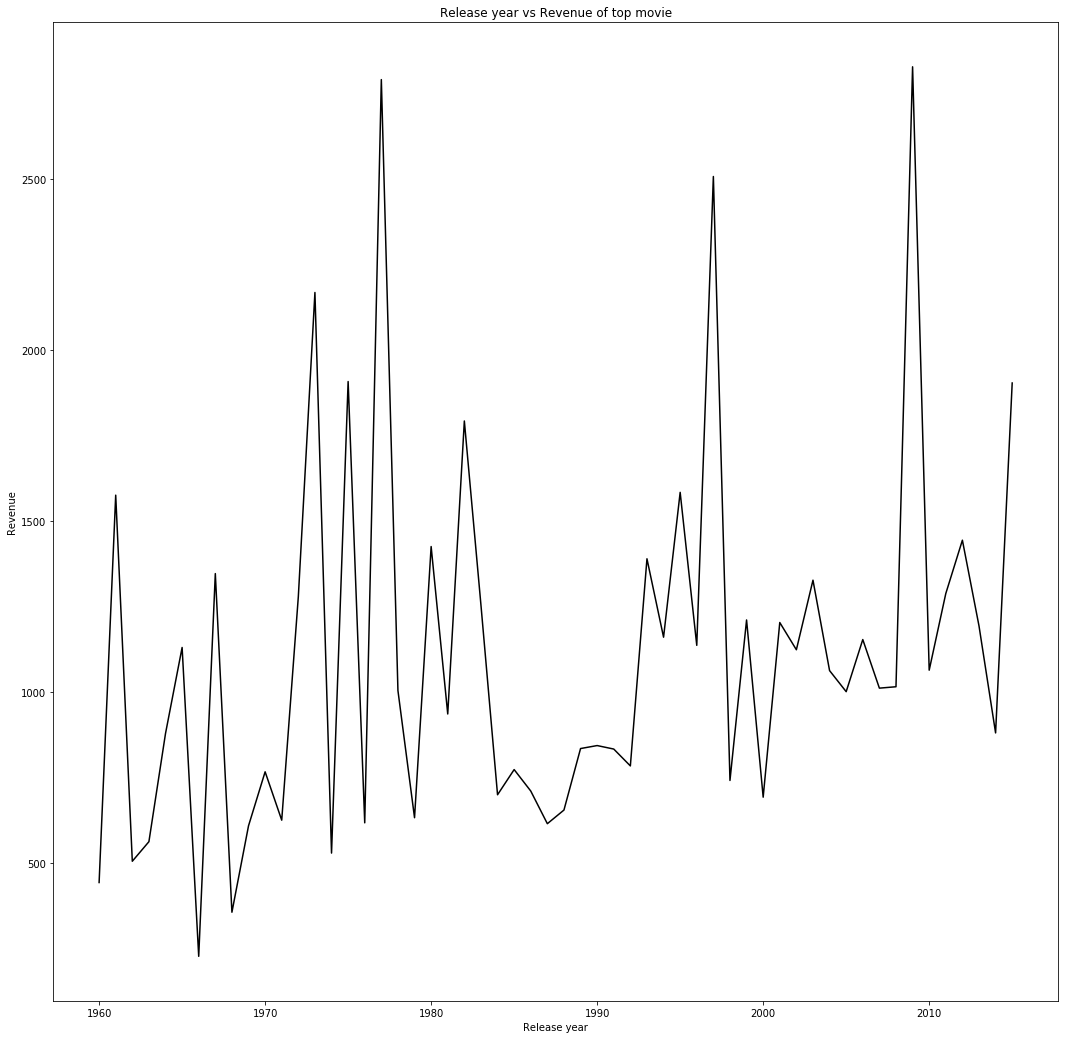

In [19]:
x = range(1960, 2016)
# These numbers come from SELECT release_year, MAX(revenue_adj_mil) FROM movies GROUP BY release_year;
y = [442.378047431774, 1574.81473970476, 504.591421513327, 561.773358994459, 878.080399544157, 1129.53486199357, 226.64357237149198, 1345.5510589884, 355.546597206549, 608.151066341555, 766.07264210816, 624.6826100747301, 1277.91373238977, 2167.32490119974, 528.462924677449, 1907.0058419157601, 616.9033825847021, 2789.71224227745, 1003.53897739431, 631.857706726084, 1424.62618777282, 935.116878227065, 1791.69430924878, 1253.81898111608, 698.9809990516519, 772.5727717137349, 709.881085221197, 614.385336766952, 654.2594343606139, 834.06106527294, 842.793762858863, 832.568277803697, 783.3062658568749, 1388.86331175898, 1159.59159000826, 1583.04953635242, 1135.7643515897, 2506.4057354194697, 740.815170215728, 1209.98053045701, 691.88694873239, 1202.51803606708, 1122.90245441715, 1326.27801047567, 1061.90362274202, 1000.35253922682, 1152.6913518711901, 1010.65350790891, 1014.7330324816801, 2827.12375041189, 1063.171911, 1287.1839975648702, 1443.1914352060699, 1192.7114911198498, 879.752289141534, 1902.72312980182]

plt.figure(figsize=(18,18))
plt.plot(x, y, color='k')

plt.xlabel('Release year')
plt.ylabel('Revenue')

plt.title('Release year vs Revenue of top movie')

plt.show()

Wow, fluctuates wildly, to put it mildly.

Now let's have a look at genres, keywords, directors, cast members, and production companies for the top movie of each year.

In [20]:
def print_from_list_with_year_additional_field(df_movies, title, additional_field, additional_title, id_list):
    year_list = []
    # I originally tried to put titles in these lists, but they wouldn't fit in the screen width when output
    # title_list = []
    additional_list = []
    for idcode in id_list:
        year_list.append(df_movies.loc[(df_movies['id'] == idcode)]['release_year'].values[0])
        #title_list.append(df_movies.loc[(df_movies['id'] == idcode)]['original_title'].values[0])
        additional_list.append(df_movies.loc[(df_movies['id'] == idcode)][additional_field].values[0])
    # df_combined = pd.DataFrame({' Year': year_list, 'Movie Title': title_list, additional_title: additional_list})
    df_combined = pd.DataFrame({' Year': year_list, additional_title: additional_list})
    print(title)
    print(df_combined)
    
by_year_movie_id_list = [967, 12230, 947, 657, 658, 15121, 396, 9325, 62, 642, 9062, 681, 238, 9552, 11072, 578, 19610, 11, 1924, 698, 1891, 85, 601, 1892, 87, 105, 744, 10998, 380, 89, 251, 280, 812, 329, 8587, 1642, 602, 597, 95, 1893, 955, 671, 121, 122, 809, 674, 58, 285, 155, 19995, 10193, 12445, 24428, 109445, 122917, 140607]
print_from_list_with_year_additional_field(df_movies, 'Genre(s) of the top movie by year', 'genres', 'Genres', by_year_movie_id_list)
print("")
print_from_list_with_year_additional_field(df_movies, 'Keyword(s) of the top movie by year', 'keywords', 'Keywords', by_year_movie_id_list)
print("")
print_from_list_with_year_additional_field(df_movies, 'Director of the top movie by year', 'director', 'Director', by_year_movie_id_list)
print("")
print_from_list_with_year_additional_field(df_movies, 'Cast of the top movie by year', 'cast', 'Cast', by_year_movie_id_list)
print("")
print_from_list_with_year_additional_field(df_movies, 'Production companies of the top movie by year', 'production_companies', 'Production companies', by_year_movie_id_list)


Genre(s) of the top movie by year
     Year                                     Genres
0    1960                       Action|Drama|History
1    1961          Adventure|Animation|Comedy|Family
2    1962                Adventure|Drama|History|War
3    1963                  Action|Thriller|Adventure
4    1964                  Adventure|Action|Thriller
5    1965                 Drama|Family|Music|Romance
6    1966                                      Drama
7    1967                 Family|Animation|Adventure
8    1968          Science Fiction|Mystery|Adventure
9    1969                History|Drama|Western|Crime
10   1970                              Drama|Romance
11   1971  Adventure|Action|Thriller|Science Fiction
12   1972                                Drama|Crime
13   1973                      Drama|Horror|Thriller
14   1974                             Comedy|Western
15   1975                  Horror|Thriller|Adventure
16   1976                        Drama|Music|Romance
17   1977   

Given how wildly the top movie from each year fluctuates in terms of revenue -- an interesting discovery in its own right -- I don't think the top movie is anything reliable to go by so I don't think these lists of what the top genres, keywords, etc, were over the course of this 56 year (1960 to 2015) period are reliable at all. At best, they give you a little bit of the flavor of how movie audiences' tastes have changed, but clearly a deeper statistical analysis is needed.

Also, I wanted to include the movie titles, but they didn't fit horizontally. In case you're wondering why they were not included in these lists. There is probably a more elegant way to list out things rather than just using "print" on a Pandas dataframe.

<a id='conclusions'></a>
## Conclusions

This was a fun little foray into some movie data, but we should be cautious about drawing any firm conclusions from it.

First of all, I happen to know, as an occasional movie fan, that IMDB adds thousands of movies to their database every year. The 10,865 movies movies we have here are a tiny fraction of the movie industry. Furthermore, since the question we started with is "what makes money", we were further reduced to 4,849 movies for which we have a revenue figure. (We were able to use all 10,865 movies for popularity and votes, however). 4,849 movies is a tiny fraction of the movie industry! While we have most of the famous movies in this database, if you're a movie studio executive contemplating green-lighting a film, you would want an analysis done with "all" the films, and should be very skittish about using any conclusions from this analysis!

We should assume our dataset is highly non-random. If you think about it, this actually invalidates most of our statistical analysis. If you what to do statistics on the height of people in the US and you took a random sample of 1,000 people, you could do that. If your sample is all from Walnut, Iowa, then you really can't do valid statistics -- your sample is non-random. As such, you should assume all the p-values here are very innacurate. One way I could have compensated for this, somewhat, would be to use a lower cutoff. I used a cutoff of 0.05 throughout, but given the non-randomness of the sample, a p-value of 0.05 shouldn't really be assumed to mean there's only a 1 in 20 chance of the observed effect being the result of random chance. I don't really know what a proper choice of p-value cutoff is.

Furthermore, while we looked at revenue, we didn't look at profit -- the difference between revenue and budget. I actually did a quick glance at profit by genre, and it looked the same as revenue by genre, even when I looked at it as a ratio (revenue as a ratio of budget, or ROI) or as a difference (revenue minus budget). However, if you a movie studio executive contemplating funding a film, you should probably revisit this and make absolutely sure you properly account for profit instead of revenue. While it's great to make a movie that has huge revenues, there's always the danger of making a high-budget movie that fails, and that can hurt your pocketbook a lot.

I already mentioned the issue of there being keywords with almost the same meaning that need to be combined, and there are production companies with similar names that need to be researched to determine if they are the same business entity.

In the analysis of production companies, one of them had "Nan"s ("not a number") come up in the results. There were also some Python warnings issued when the analysis code ran (from statsmodels and scipy/stats). The warnings might or might not be related to the NaNs. Because this is just an initial foray into the data, I didn't try to determine the cause of either the NaNs or the Python warnings. In a proper investigation, these would need to be scrutinized to determine if they are affecting the analysis.

There were fields that I did not even attempt to analyze, like "tagline" and "overview", that were free text fields. For these, you'd need a neural network or somesuch. It's not obvious to me at this time what the appropriate output for a neural network that you feed those fields into would be. However, there is probably a way of using them to improve the analysis.

When I first set out to do this project, my first thought was that I'd better find all the meaningful patterns in this data, because thousands of other students have already looked at it and all the possible patterns are already known, and I wasn't going to impress the reviewer unless I found them all or a good portion of them. I knew xgboost was winning Kaggle competitions when structured data was in play, so I tried using xgboost on this data. I was able to generate some trees but quickly realized, I could not explain these results to humans, and this project was all about explaining the data to humans. So after realizing that, I went back to the much simpler technique of linear regression, which I thought would give me results I could explain to humans. However, if you really were a movie studio executive betting real money on films, you'd want the most predictive model possible, and linear regression is not the state of the art in that regard. You'd probably want to use a model produced by xgboost, maybe combined with neural networks to crack the free-form text fields, as mentioned above, even if the model is an inscrutable black box that can't be explained to humans in a Jupyter notebook. And of course, you'd want to do this on a much bigger dataset.

Finally, if you were a movie company executive contemplating funding a film, you shouldn't assume that what has worked in the past will continue to work into the future. For example, this data shows that the best keyword to generate revenue is "animation". But maybe lots of movie companies know this and the market is about to be flooded with animated movies, audiences will grow tired of animated movies, seek something different, and the "animation" keyword will drop in value. Some ideas gain in value the more people use them, but some ideas become overused and their value diminishes with overuse.

My analysis of how genres, keywords, directors, cast, and production companies change over time was laughably inadaquate -- I only looked at the top movie from each year and did not statistics. As noted above I got caught by my own decision to do a few steps manually instead of pulling the relevant numbers out of statsmodels in code, and that decision probably turned out to be a bad one because it made doing a loop that did a "by year" analysis too tedious to do by hand. In the future as soon as I need those numbers from statsmodels I will figure out how to pull them out programmatically.

In short, much as I would like to think I came up with pretty good advice as to how to make a money-making movie -- namely, "Shrek Saves the World" from Dreamworks Animation in 3D with Shrek on his first day of helicopter piloting school for the opening scene (because the movie has to have lots of flying) -- if you're a movie company executive looking to fund a movie, my analysis probably isn't a good way to decide what movie to fund. However, I noticed one of the example questions for this dataset is, "What kinds of properties are associated with movies that have high revenues?", which is essentially the same as the first question that popped into my mind, "What makes money?", so I have to imagine thousands of other students have done the same kind of analysis as I did here, and for ones who did a better analysis, I'd like to see how they did it.


## Replication

I've added a section here to explain the full process of replicating the results, since I wasn't able to do everything within a Jupyter notebook, replication of results is required according to the rubric, and there were steps I did manually.

First, you will need a machine with statsmodels installed. I wasn't able to import statsmodels in the Jupyter notebook, and, as noted in the text, I was unable to get p-values from scikit-learn (though I was able to get coefficients and demonstrated that -- if coefficients were all that I had used for the analysis I could have done that in the notebook), so you will need a machine with statsmodels installed to replicate this. Maybe there is a way to install statsmodels on Udacity's servers for the notebook -- if so, I didn't try to do that.

I think sqlite3 comes with Python 3 but if it doesn't, you'll need to install that, too.

I made a manual change to the CSV file itself. This is because there was a duplicate entry. When pulling into SQL, I get a "UNIQUE constraint failed: movies.id" error if the duplicate was not removed. This is because I declared the "id" field to be the primary key and SQL does not allow duplicate primary keys. The entry that was removed was: id = 42194 ("TEKKEN"). So to replicate the results, you will have to repeat this modification to the original file. It doesn't matter which entry you delete because they are identical.

Originally "cast" caused a problem because it was a reserved word in SQL, but I was able to address this in the code and so the column name in the file doesn't need to be changed. As the CSV file gets imported, there is a rename_fields parameter and "cast" is renamed to "performers" during the import process. Unfortunately, I couldn't think of a way to fix the duplicate entry in code. It seems like the code should throw that back to the human because a human should resolve whether the duplicate ID means one should be deleted, or there should be two, or whatever.

Once you've done that, you'll need to go to this link on GitHub to pull down the code:

https://github.com/waynerad/analyzetmdb


In the file tmdb.py, you'll need to go to line 331 where there is a 'path' variable, and set it to the path to the directory that you are running this code in. If you called your modified version of the TMDb CSV with the duplicate entry removed 'tmdb-movies-modified.csv' then you don't need to change the following line, otherwise change the following line with the filename for your modified CSV file.

At this point you should be able to run

python3 tmdb.py

All the statsmodels output will be output in the main output.

The ranked lists will be output separately into their own CSV files. The "max revenue movie of each year" data is also output into separate CSV. So you should see a series of CSV files get created. The same 'path' variable will be used to write these files.

This is the point where the manual work I did that turned out to be tedious was. Yes, as I acknowledged above, I realize it was a mistake not to automate this. Anyway, you can see the results of my manual filtering and sorting here, and should be able to replicate these results yourself, though I don't recommend it just due to the tedium of it:

https://docs.google.com/spreadsheets/d/1PV2U8py3Zss2pDM4k4bN-asBXuToXsggAJnkoVyXjtw/edit?usp=sharing


At this point I think I've covered everything in the rubric, but there's a few things I still worry about. One is the "both single-variable (1d) and multiple-variable (2d) explorations". I'm not sure what this means. I'm hoping my tables count as "1d" and my graphs count as "2d", but since I don't really know what is meant, I don't know.

The other thing I worry about is the Pandas requirements: "The project uses NumPy arrays and Pandas Series and DataFrames where appropriate rather than Python lists and dictionaries. Where possible, vectorized operations and built-in functions are used instead of loops," and "Utilize NumPy or Pandas functionality that goes beyond what was covered in the course." I'm pretty sure it's possible for my helper functions like "print_top_from_list" to be done with 1 line of Pandas code, and I spent a lot of time on Stack Overflow trying to figure out what it was, only to give up and resort to Python lists and loops. If doing the Pandas 1-liner is a requirement, I'm in trouble.

Besides that, due to my frustration with Pandas, I created an SQL tool that outputs Pandas dataframes, so I could do all the data manipulation in SQL and only switch to a Pandas dataframe at the very last step, when a Pandas dataframe was required by some external system, such as statsmodels or matplotlib. I can say without reservation that Pandas is the most difficult piece of software I have ever encountered in my life. I've felt again and again and again that the question I need the answer to is "How does Pandas think?", but of course you can't ask that question on the Udacity forums or anywhere else -- if you did, people would probably think you're trolling. It's been about 2 years since I first encountered Pandas, and I've tried reading source code, reading as much of the documentation on the website as humanly possible (I thought if I just read and read and read sooner or later everything would 'gel' in my brain and Pandas would make sense), and at one point when I realized Pandas was an attempt to bring R concepts over to Python (dataframes, for example, are a built-in data structure in R), I stopped everything and learned R, and then came back to Pandas in Python. This has all been to no avail. I still don't understand the "theory of operation" of Pandas. I know "theory of operation" is an antiquated term from the Olden Days of the computer age, but I can't think of a better term. "Theory of operation" doesn't refer to how a program works internally, it refers to the mental model of how the program works that the user of the program needs to have to use it correctly. I've begun to wonder whether people learn the "theory of operation" of Pandas by word-of-mouth, by having a Pandas expert sitting next to them, and not online. On the surface, Pandas looks so deceptively simple -- dataframes are these simple things with rows and columns, and each column has a type, and the rows and columns have names, and they're also numbered. It seems so simple. Until you try to write some code to manipulate data in dataframes, and realize you don't know how to do it. You consult some cheat sheets, you try some things, nothing works, you get inscrutable error messages, you search for them on Stack Overflow, and repeat with more trial-and-error. You might get a solution to one specific problem, but still be in the dark as to the "theory of operation" of Pandas. The SQL world is completely different. SQL databases are based on the relational model. The relational model is mathematically rigorous, because it's based on set theory. Once you understand the relational model and the basics of the SQL language, the "theory of operation" is straightforward, with the caveat that every SQL database has it's own flavor of the SQL language that it understands. I had this idea for at least 6 months or so of working around the frustrations of Pandas by using SQL, but always figured it would be too much work. But on this project, I decided before bombarding forums with questions, I'd take a peek and see how much work it actually was. It looked like sqlite3 would be easy to use from Python, so I decided to give it a try. It was easy and everything worked straight away, so I ran with it. For the most part, the hours of headbanging to figure out arcane syntax that working with Pandas entails is completely absent with SQL. The only place on this project some difficulty would have come into play is where I did a GROUP BY and looped through the results, doing another query in the loop -- something that I'm sure could have been done in a single query, but I didn't go through the effort of figuring it out. Though I can't imagine doing the same thing in Pandas would've been any easier. But I could be wrong; maybe Pandas is no problem for the other data science students, only me. Anyway, I'm explaining all this because I feel I need to explain why I took the detour into SQL instead of doing everything in Pandas.

The project does say "You should also feel free to use other tools and software to craft your final report, but make sure that you can submit your report as an HTML or PDF file so that it can be opened easily," so using the SQL-to-Pandas tool should be allowed.

I'm hoping that my SQL-to-Pandas tool will help me zip through all the remaining projects because I'm so far behind. In this project, if I could do it again I think I'd find a way to get the output from statsmodels into an SQL table. Filtering by p-value and sorting by coefficient would just be "WHERE p <= 0.05 ORDER BY coeff DESC" in SQL. Next time I need coefficients and p-values from statsmodels, I'll take the trouble to figure out how to get that information out of statsmodels and into an SQL table. Seems like the way to go is do all data manipulation in SQL, then pop out a Pandas dataframe as the last step in the process.

In [21]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0